<a href="https://colab.research.google.com/github/aqramlee/optimisation/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

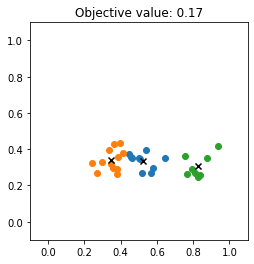

In [4]:
import random
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

from tkinter import *



class Instance:
    def __init__(self, data, k):
        self.data = data
        self.k = k


class Solution:
    def __init__(self, instance):
        self.instance = instance
        self.classes = [0] * len(instance.data)

    def update_classes(self, centroids):
        def lists_different(list1, list2):
            return len(list1) != len(list2) or any(list1[i] != list2[i] for i in range(len(list1)))

        def closest(point):
            x, y = point
            dist = [(x - cx) ** 2 + (y - cy) ** 2 for (cx, cy) in centroids]
            return np.argmin(dist)

        prev_classes = self.classes
        self.classes = [closest(d) for d in self.instance.data]
        return lists_different(self.classes, prev_classes)

    def calculate_centroids(self):
        def center_of_mass(points):
            if len(points) == 0:
                return 0.5, 0.5

            return sum([x for (x, _) in points]) / len(points), sum([y for (_, y) in points]) / len(points)

        return [center_of_mass([self.instance.data[j] for j in range(len(self.instance.data))
                                if self.classes[j] == i]) for i in range(self.instance.k)]

    def get_objective(self, centroids=None):
        if centroids is None:
            centroids = self.calculate_centroids()

        return sum((self.instance.data[i][0] - centroids[self.classes[i]][0]) ** 2
               + (self.instance.data[i][1] - centroids[self.classes[i]][1]) ** 2 for i in range(len(self.instance.data)))


def construction_uniform_random(instance):
    solution = Solution(instance)
    centroids = [(random.random(), random.random()) for _ in range(instance.k)]
    solution.update_classes(centroids)
    return solution


def construction_random_partition(instance):
    solution = Solution(instance)
    solution.classes = [random.randint(0, instance.k - 1) for _ in range(len(instance.data))]
    return solution


def construction_forgy(instance):
    solution = Solution(instance)
    centroids = random.choices(instance.data, k=instance.k)
    solution.update_classes(centroids)
    return solution


def kmeans(instance, construction):
    solution = construction(instance)

    modified = True
    while modified:
        centroids = solution.calculate_centroids()
        modified = solution.update_classes(centroids)

    return solution, centroids


def plot_dataset(solution, axes):
    for i in range(solution.instance.k):
        points = [solution.instance.data[j] for j in range(len(solution.instance.data)) if solution.classes[j] == i]
        if len(points) > 0:
            axes.scatter(*zip(*points))


def plot_centroids(centroids, axes):
    axes.scatter(*zip(*centroids), marker='x', c='black')


def plot(solution, centroids):
    plt.gca().set_aspect('equal', 'box')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plot_dataset(solution, plt.gca())
    plot_centroids(centroids, plt.gca())
    plt.title(f'Objective value: {solution.get_objective(centroids):.2f}')
    plt.show()


def multi_start(instance, construction, iterations):
    best_objective = sys.float_info.max
    best_solution = None
    for i in range(iterations):
        solution, centroids = kmeans(instance, construction)
        objective = solution.get_objective(centroids)
        if objective < best_objective:
            best_solution = solution
            best_objective = objective
        print(f'{objective:.2f}')

    return best_solution, best_solution.calculate_centroids()


def uniform_data(n):
    return [(random.random(), random.random()) for _ in range(n)]


def clustered_data(n, k):
    c = [(random.random() * 0.6 + 0.2, random.random() * 0.6 + 0.2) for _ in range(k)]
    return [(c[i][0] + random.random() * 0.2, c[i][1] + random.random() * 0.2) for i in random.choices(range(k), k=n)]


def uniform_data_1d(n):
    return [(random.random(), 0) for _ in range(n)]


def test_kmeans(instance, construction):
    solution, centroids = kmeans(instance, construction)
    plot(solution, centroids)


def test_multi_start(instance, construction, iterations):
    solution, centroids = multi_start(instance, construction, iterations)
    plot(solution, centroids)


running = True
iteration = 0
animation_centroids = []


class AnimationWindow:
    def __init__(self,  window, instance, construction):
        self.window = window

        self.playing = False
        self.iteration = 0
        self.finished = False
        self.scheduled_play = None

        panel = PanedWindow(window)
        self.button_next = Button(panel, text="Next", command=self.next)
        self.button_play = Button(panel, text="Play", command=self.play)
        self.button_next.pack(side=LEFT)
        self.button_play.pack(side=LEFT)
        self.slider = Scale(panel, from_=0, to=5, orient='horizontal', command=self.slider_moved, showvalue=0, label='Speed')
        self.slider.pack(side=LEFT)
        self.button_reset = Button(panel, text="Reset", command=self.reset)
        self.button_reset.pack(side=LEFT)
        panel.pack(side=TOP)

        self.instance = instance
        self.construction = construction
        self.solution = self.construction(self.instance)
        self.construction = construction
        self.animation_centroids = self.solution.calculate_centroids()
        self.fig = Figure()
        self.axes = self.fig.add_subplot()

        self.canvas = FigureCanvasTkAgg(self.fig, master=self.window)
        self.canvas.get_tk_widget().pack(fill=BOTH, side=TOP, expand=1)
        self.plot()

    def reset(self):
        self.window.after_cancel(self.scheduled_play)
        self.playing = False
        self.finished = False
        self.iteration = 0
        self.solution = self.construction(self.instance)
        self.animation_centroids = self.solution.calculate_centroids()

        self.button_next['state'] = NORMAL
        self.button_play['state'] = NORMAL

        self.plot()

    def slider_moved(self, _):
        self.window.after_cancel(self.scheduled_play)
        if self.playing:
            self.play()

    def next(self):
        if self.finished:
            return

        self.iteration += 1

        if self.iteration % 2 == 0:
            self.animation_centroids = self.solution.calculate_centroids()
        else:
            self.finished = not self.solution.update_classes(self.animation_centroids)
            if self.finished:
                self.button_next['state'] = DISABLED
                self.button_play['state'] = DISABLED

        self.plot()

    def play(self):
        self.playing = True
        self.next()
        if self.finished:
            self.playing = False
        else:
            self.scheduled_play = self.window.after(int(1000 / (2**self.slider.get())), self.play)

    def plot(self):
        self.axes.cla()
        self.axes.set_aspect('equal', 'box')
        self.axes.set_xlim([-0.1, 1.1])
        self.axes.set_ylim([-0.1, 1.1])

        self.axes.set_ylabel("Y", fontsize=14)
        self.axes.set_xlabel("X", fontsize=14)

        plot_dataset(self.solution, self.axes)
        plot_centroids(self.animation_centroids, self.axes)
        self.window.title(f'Objective value: {self.solution.get_objective(self.animation_centroids):.2f}; iteration {self.iteration}')
        self.canvas.draw()


def animate_kmeans(instance, construction):
    window = Tk()
    window.state('zoomed')
    AnimationWindow(window, instance, construction)
    window.mainloop()


def measure_average_quality(instance, construction, iterations):
    total = 0
    for i in range(iterations):
        solution, centroids = kmeans(instance, construction)
        total += solution.get_objective(centroids)

    print(f'Average objective value: {total / iterations:.2f}')


def local_search(solution):
    # This line calculates the objective value of the solution:
    cur_obj = solution.get_objective()

    # Implement a local search procedure here.  Suggested neighbourhood: for each element, try to change its class and
    # keep the new class if this change improved the solution.  Repeat the neighbourhood exploration until
    # the local search is 'stuck'.

    # The instance data is available via solution.instance.data and solution.instance.k.
    # The class of element i is accessible via solution.classes[i].

    return solution


def test_local_search(instance, construction):
    solution = construction(instance)
    solution = local_search(solution)
    plot(solution, solution.calculate_centroids())


def main():
    random.seed(123)
    data = clustered_data(30, 3)
    # data = uniform_data(1000)
    # data = uniform_data_1d(50)

    instance = Instance(data, 3)

    # random.seed()

    test_kmeans(instance, construction_uniform_random)
    # animate_kmeans(instance, construction_uniform_random)

    # test_multi_start(instance, construction_uniform_random, 10)

    # measure_average_quality(instance, construction_random_partition, 100)
    # measure_average_quality(instance, construction_uniform_random, 100)
    # measure_average_quality(instance, construction_forgy, 100)

    # test_local_search(instance, construction_uniform_random)


main()
